# Data cleaning and description

In [20]:
#%%capture
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle 
import networkx as nx
from tqdm import tqdm
import os
import requests
import zipfile
from utils import get_referenced_by

Import data as a panda dataframe

In [21]:

class CitationDataset:
    """
    Object for downloading, unzipping and loading the citation dataset.
    If you already have the downloaded zip file, put it into a folder named DATA.
    """

    def __init__(self, cache_dir: str = "") -> None:
        if not cache_dir:
            self._base_path = os.getcwd()
        else:
            self._base_path = cache_dir

        self._folder_path: str = self._base_path + "/DATA"
        self._subfolder_path: str = self._folder_path + "/dblp-ref"
        self._zip_path: str = self._folder_path + "/dblp.v10.zip"
        self._file_paths: list[str] = [
            self._subfolder_path + f"/dblp-ref-{i}.json" for i in range(4)
        ]
        self._file_url = f"https://lfs.aminer.cn/lab-datasets/citation/dblp.v10.zip"

        if not self._cache_exists():
            if not self._zip_exists():
                self._download_to_cache()
            self._unzip()

    def _zip_exists(self) -> bool:
        return os.path.isfile(self._zip_path)

    def _cache_exists(self) -> bool:
        """check that all four files exists in the folder"""
        return all((os.path.isfile(file_path) for file_path in self._file_paths))

    def _download_to_cache(self) -> None:
        print(f"Downloading data from {self._file_url}")

        if not os.path.exists(self._folder_path):
            os.makedirs(self._folder_path)

        # download content with context bar
        response = requests.get(self._file_url, stream=True)
        progress_bar = tqdm(
            total=int(response.headers.get("content-length", 0)),
            unit="B",
            unit_scale=True,
        )

        with open(self._zip_path, "wb") as file:
            for data in response.iter_content(chunk_size=4096):
                file.write(data)
                progress_bar.update(len(data))  # Update the progress bar

        progress_bar.close()

    def _unzip(self) -> None:
        print("unzipping", self._zip_path)
        with zipfile.ZipFile(self._zip_path, "r") as zip_ref:
            zip_ref.extractall(self._folder_path)

    def load_dataframe(self, *, subset=False) -> pd.DataFrame:
        """
        Load data from cache as a pandas DataFrame.
        Set subset = True to only use the smallest of the four files.
        """
        print("loading dataframe from cache", self._subfolder_path)
        

        df = pd.DataFrame()
        for file in reversed(self._file_paths):
            print("loading", file)
            df = pd.concat((df, pd.read_json(file, lines=True)))
            if subset:  # stop after reading the last, and smallest of the json files
                break

        df.references = df.references.fillna("")
        df.abstract = df.abstract.fillna("")
        
        df = get_referenced_by(df)

        return df

    def load_graph(self, df: pd.DataFrame) -> nx.Graph:
        """
        Loads networkx DiGraph from dataframe.
        """
        # Create an empty directed graph
        G = nx.DiGraph()
        
        # Iterate through the DataFrame and add nodes and edges to the graph
        for _, row in tqdm(df.iterrows(), total=len(df)):
            node_id = row.id
            references = row.references

            # Add the node to the graph
            G.add_node(
                node_id,
                abstract=row.abstract,
                authors=row.authors,
                n_citation=row.n_citation,
                title=row.title,
                venue=row.venue,
                year=row.year,
            )

            # Add edges from the node to its references
            for reference in references:
                if reference in df['id']:
                    G.add_edge(node_id, reference)
                else:
                    print(f"Reference {reference} not found in the DataFrame.")
        return G


if __name__ == "__main__":
    dataset = CitationDataset()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.85G/1.85G [03:58<00:00, 7.74MB/s]


unzipping /zhome/5e/c/137246/02807_project/DATA/dblp.v10.zip


In [22]:
df = dataset.load_dataframe()


loading dataframe from cache /zhome/5e/c/137246/02807_project/DATA/dblp-ref
loading /zhome/5e/c/137246/02807_project/DATA/dblp-ref/dblp-ref-3.json
loading /zhome/5e/c/137246/02807_project/DATA/dblp-ref/dblp-ref-2.json
loading /zhome/5e/c/137246/02807_project/DATA/dblp-ref/dblp-ref-1.json
loading /zhome/5e/c/137246/02807_project/DATA/dblp-ref/dblp-ref-0.json


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3079007/3079007 [02:27<00:00, 20872.98it/s]


Number of papers: 3079007


<Axes: >

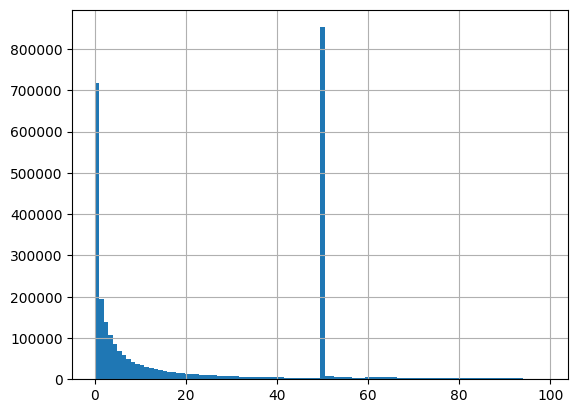

In [11]:
print('Number of papers: {}'.format(len(df)))
df['n_citation'].hist(bins=100, range=(0, 99))

We see that the most commen number of citations are 50? (weirdly enough)

In [12]:
df['n_citation'].describe()


count    3.079007e+06
mean     3.522090e+01
std      1.577007e+02
min      0.000000e+00
25%      1.000000e+00
50%      1.100000e+01
75%      5.000000e+01
max      7.336200e+04
Name: n_citation, dtype: float64

In [13]:
print('Number of papers with 0 citations: {}'.format(len(df[df['n_citation'] == 0])))
print('Max citations: {}'.format(df['n_citation'].max()))
print('Mean citations: {}'.format(df['n_citation'].mean()))

Number of papers with 0 citations: 718250
Max citations: 73362
Mean citations: 35.220902713114974


Now we delete all papers with 0 and 50 citations

In [14]:
df = df[(df[['abstract']] != '').all(axis=1)]
df = df[(df[['n_citation']] != 0).all(axis=1)]
df = df[(df[['n_citation']] != 50).all(axis=1)]


In [15]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id,referenced_by,n_counted_citations,n_references
0,AdaBoost algorithm based on Haar-like features...,"[Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...",0,"[0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...",A Heterogeneous System for Real-Time Detection...,high performance computing and communications,2016,001eef4f-1d00-4ae6-8b4f-7e66344bbc6e,NaN,0,8
1,"In this paper, a kind of novel jigsaw EBG stru...","[Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]",0,[],A novel conformal jigsaw EBG structure design,international conference on conceptual structures,2016,002e0b7e-d62f-4140-b015-1fe29a9acbaa,NaN,0,0
2,This paper studies the problem of using an aut...,"[Xiaodong Ai, Keyou You, Shiji Song]",0,"[1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...",A source-seeking strategy for an autonomous un...,"international conference on control, automatio...",2016,00352759-f0a7-4678-82ae-fed68c700da6,NaN,0,5
3,,"[Francine Berman, Vinton G. Cerf]",0,[],Social and ethical behavior in the internet of...,Communications of The ACM,2017,00f77fa9-ae49-4935-9166-2f5f9cdb3d6b,NaN,0,0
4,,"[Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...",50,"[4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...",Prediction of consensus binding mode geometrie...,Journal of Computational Chemistry,2017,013ea675-bb58-42f8-a423-f5534546b2b1,[71039ab8-941f-4c6f-bdb8-77a6519f45a0],1,2


Number of papers: 1297860
Mean citations: 46.46594624998074


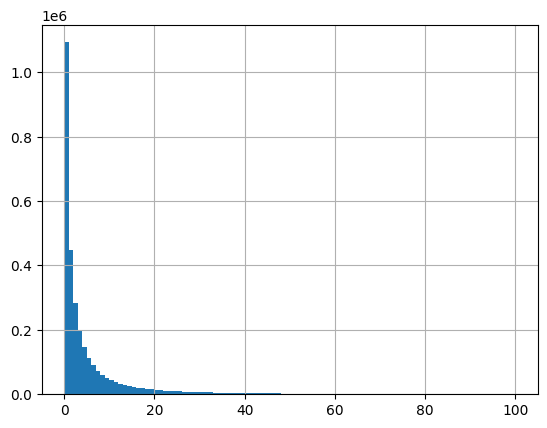

In [46]:
print('Number of papers: {}'.format(len(df)))
df['n_counted_citations'].hist(bins=100, range= (0,100))
plt.show()

We see that the most commen number of citations are 50? (weirdly enough)

count    3.079007e+06
mean     8.173737e+00
std      4.551554e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      6.000000e+00
max      1.622900e+04
Name: n_counted_citations, dtype: float64

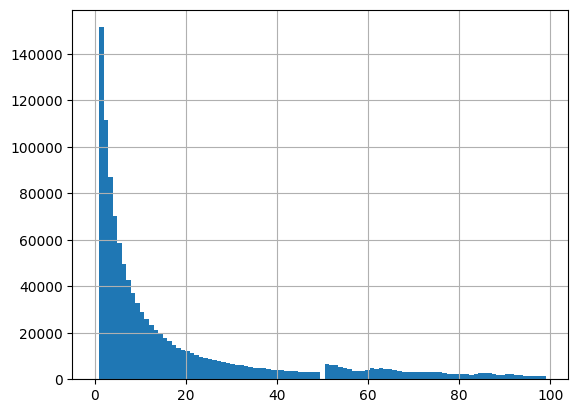

In [73]:
df['n_counted_citations'].describe()


In [48]:
print('Number of papers with 0 citations: {}'.format(len(df[df['n_counted_citations'] == 0])))
print('Max citations: {}'.format(df['n_counted_citations'].max()))
print('Mean citations: {}'.format(round(df['n_counted_citations'].mean(),1)))

Number of papers with 0 citations: 1093086
Max citations: 16229
Mean citations: 8.2


Now we delete all papers with 0 and 50 citations

In [49]:
df = df[(df[['n_counted_citations']] != 0).all(axis=1)]
df = df[(df[['n_references']] != 0).all(axis=1)]
df = df[(df[['abstract']] != '').all(axis=1)]

In [50]:
df.head()

,abstract,authors,n_citation,references,title,venue,year,id,referenced_by,n_counted_citations,n_references
10,For stereoscopic optical see-through head-moun...,"[Long Qian, Alexander Winkler, Bernhard Fuerst...",50,"[076bca9b-b30c-4c2c-8148-3b9b5d9aa939, 6b5cf40...",Modeling Physical Structure as Additional Cons...,international symposium on mixed and augmented...,2016,01f02fae-97df-4207-a386-a1bc8ec0853b,[2ced1d5a-a5ff-4860-99d2-9832b11b1f40],1,5
29,For the multiterminal secret key agreement pro...,"[Chung Chan, Manuj Mukherjee, Navin Kashyap, Q...",50,"[19eb4d23-c01f-484a-ad86-0f1061622295, 205c230...",Secret Key Agreement under Discussion Rate Con...,arXiv: Information Theory,2017,0600c67e-71a1-4ed2-913f-e9db02370de4,[ca159cfa-0424-4066-bc21-088a548c6cea],1,13
48,Semantic image segmentation is a fundamental t...,"[Tong Shen, Guosheng Lin, Chunhua Shen, Ian D....",50,"[031bbeb0-4dc1-46f9-9984-109c3b3eefae, 153c501...",Learning Multi-level Region Consistency with D...,arXiv: Computer Vision and Pattern Recognition,2017,0a2562d0-f2af-47e1-a783-02aac8607c7b,[604aa9c4-1d9a-4c6c-be04-ee57d0bbe157],1,17
83,"Nearly fifteen years ago, Google unveiled the ...","[Christopher A. Wilkens, Ruggiero Cavallo, Rad...",50,"[03320467-a15f-43df-bcfc-cfe86c167b50, 21da5d1...",GSP: The Cinderella of Mechanism Design,international world wide web conferences,2017,108d3159-2542-4974-95d0-1962972a9fa1,[a8a108cc-8c99-4058-acc0-e43267262c4a],1,13
86,Data analytics frameworks shift towards larger...,"[Jinwei Liu, Haiying Shen]",50,"[004b7183-1fb5-4e08-b29a-87c679316171, 0150e04...",Dependency-Aware and Resource-Efficient Schedu...,ieee international conference on cloud computi...,2016,11997fa1-0571-413a-bacd-4ae3162353dd,"[3387407d-780c-4059-823d-5d9c78ddb348, 95cb467...",6,39


In [52]:
print('Number of papers: {}'.format(len(df)))
print('Mean citations: {}'.format(df['n_counted_citations'].mean()))
df['n_counted_citations'].describe()


Number of papers: 1614519
Mean citations: 13.532765486191243


count    1.614519e+06
mean     1.353277e+01
std      5.619322e+01
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      1.100000e+01
max      1.622900e+04
Name: n_counted_citations, dtype: float64

In [54]:
print('Number of papers with 0 citations: {}'.format(len(df[df['n_counted_citations'] == 0])))
print('Max citations: {}'.format(df['n_counted_citations'].max()))
print('Mean citations: {}'.format(round(df['n_counted_citations'].mean(),1)))

Number of papers with 0 citations: 0
Max citations: 16229
Mean citations: 13.5


Load graph

In [62]:
def load_graph(df):
    """
    Loads networkx DiGraph from dataframe.
    """
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Create a set of all the paper IDs
    id_set = set(df['id'])
    
    # Iterate through the DataFrame and add nodes and edges to the graph
    for _, row in tqdm(df.iterrows(), total=len(df)):
        node_id = row.id
        references = row.references

        # Add the node to the graph
        G.add_node(
            node_id,
            abstract=row.abstract,
            n_references=row.n_references,
            n_citation=row.n_counted_citations,
            referenced_by=row.referenced_by,  
            title=row.title,
        )
        
        # Add edges from the node to its references
        for reference in references:
            if reference in id_set:
                G.add_edge(node_id, reference)
                
        for citation in row.referenced_by:
            if citation in id_set:
                G.add_edge(citation, node_id)

    return G

In [63]:
G = load_graph(df)
print("Number of nodes: ", G.number_of_nodes())
print("Number of edges: ", G.number_of_edges())

  0%|                                                                                                                   | 0/1614519 [00:00<?, ?it/s]

Number of nodes:  1297860
Number of edges:  10365410


In [65]:
pickle.dump(G, open( "base_graph.pkl", "wb" ) )

In [ ]:
## Here you open the pickle file to load the graph
with open("base_graph.pkl", 'rb') as f:
    G = pickle.load(f)